Baseline difference -11695255936.0
tail difference 1.9425156812824867e-72


C:\Users\sfska\AppData\Local\Temp\ipykernel_27624\284869011.py:48: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)


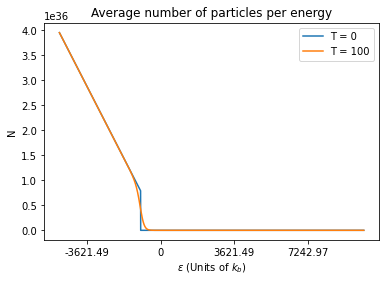

Best mu -983.4141865194125
Predicted best mu 983.413096650149


In [2]:
from matplotlib import ticker
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.integrate as integrate

hbar = 1.05457182e-34
k_b = 1.380649e-23 #m^2 kg/s^2/K
v_f = 1e6
dos_slope = 2/pi/hbar**2/v_f**2
# dos_slope = 1
bound_max = 10000


# func is a tuple of domain, range
def interp(x, func):
    domain, outs, *rest = func
    if x < domain[0] or x > domain[-1]:
        raise "x out of bounds of function"
    mini = 0
    maxi = len(domain)
    while maxi-mini > 1:
        center = (mini+maxi)//2
        if x < domain[center]:
            maxi = center
        else:
            mini = center

    m = (outs[maxi]-outs[mini])/(domain[maxi]-domain[mini])
    return m * (x-domain[mini]) + outs[mini]


j_to_ev = 6.242e18
def temp_to_ev(x):
    return x*k_b*j_to_ev

def get_diff_in_temps(func, t1, t2):
    diff = interp(t1, func) - interp(t2, func)
    return diff

def calc_mu(mu_0, T):
    return sqrt(mu_0**2-pi**2*k_b**2/3*T**2)

def DOS(x, slope=dos_slope, dirac_point=0):
    return slope*abs(x-dirac_point)

def f(x, mu, T):
    return 1/(np.exp((x-mu)/(k_b*T)) + 1)

def f_taylor(x, mu, T):
    b = np.exp(mu/(k_b*T))
    return 1/(b**-1+1) - x*b/(k_b*T*(b+1)**2) - x**2 * b * (b-1) / (2 * k_b**2 * T**2 * (b+1)**3) - x**3 * b * (-4*b + b**2 + 1) / (6 * k_b**3 * T**3 * (b+1)**4)

def compute_diff(mu1, mu2, temp):
    baseline = lambda x, mu=mu1: f(x,mu, 1e-50) * DOS(x)
    fitted = lambda x, mu=mu2, temp=temp: f(x,mu,temp) * DOS(x)

    # diffed = lambda x: fitted(x) - baseline(x)
    # left = integrate.quad(diffed, -bound_max*k_b, min(mu1,mu2), limit=250)[0]
    # middle = integrate.quad(diffed, min(mu1,mu2), max(mu1,mu2),limit=100)[0]
    # right = integrate.quad(diffed, max(mu1,mu2), bound_max*k_b,limit=100)[0]
    #
    # N_diff = left + middle + right
    N_total = 1/2*((-bound_max*k_b)**2 - mu1**2) * dos_slope
    N_fitted = integrate.quad(fitted , -bound_max*k_b, bound_max*k_b)
    diff = N_fitted[0]-N_total
    return diff

def optimize_mu(mu1, fitted_temp,threshold = 0.0001, max_steps = 1000):
    # prepare our bounds for binary search
    mini = -1 * k_b
    maxi = 1 * k_b
    while compute_diff(mu1, mini, fitted_temp) > 0:
        mini *= 2
    while compute_diff(mu1, maxi, fitted_temp) < 0:
        maxi *= 2

    mu_guess = (maxi+mini)/2
    diff = compute_diff(mu1, mu_guess, fitted_temp)
    steps = 0
    while threshold < abs(maxi-mini)+abs(diff) and steps <= max_steps:
        steps += 1
        mu_guess = (maxi+mini)/2
        diff = compute_diff(mu1, mu_guess, fitted_temp)
        # print("Steps:", steps, "Computed diff", diff)
        if diff > 0:
            maxi = mu_guess
        else:
            mini = mu_guess
    return mu_guess



mu1 = -1000 * k_b
mu2 =  -983.413096650149*k_b
temp = 100
#-2318.9150029124735
baseline = lambda x, mu=mu1: f(x,mu, 1e-50) * DOS(x)
fitted = lambda x, mu=mu2, temp=temp: f(x,mu,temp) * DOS(x)
taylor = lambda x, mu=mu2, temp=temp: f_taylor(x,mu,temp) * DOS(x)


N_total = 1/2*((-bound_max*k_b)**2 - mu1**2) * dos_slope

N_fitted = integrate.quad(fitted, -bound_max*k_b, bound_max*k_b)


print("Baseline difference", N_total-N_fitted[0])


# if this number is high need to readjust bounds
tail_sum = \
        abs(integrate.quad(baseline, -10000000*k_b, -bound_max*k_b)[0]
      -integrate.quad(fitted, -10000000*k_b, -bound_max * k_b, 0)[0]) \
       + abs(integrate.quad(baseline, bound_max*k_b, 10000000*k_b)[0]
         -integrate.quad(fitted, bound_max*k_b, 10000000 * k_b, 0)[0])
#

print("tail difference", tail_sum)

domain = np.linspace(-5000*k_b, 10000*k_b, 100000)
plt.plot(domain, baseline(domain), label="T = 0")
plt.plot(domain, fitted(domain), label ="T = {}".format(temp))

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/k_b))
plt.gca().xaxis.set_major_formatter(ticks)
plt.xlabel("$\epsilon$ (Units of $k_b$)")
plt.ylabel("N")
plt.title("Average number of particles per energy")
plt.legend()
plt.show()

print("Best mu", optimize_mu(mu1, temp)/k_b)
print("Predicted best mu", calc_mu(mu1, temp)/k_b)

shifts = np.linspace(-2320,0) * k_b

In [13]:
from tqdm import tqdm
mus = []
mu_0 = -1567*k_b
temps = np.linspace(0,200)
for temp in tqdm(temps):
    mus.append(optimize_mu(mu_0, temp) / k_b)


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\268369709.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\268369709.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\268369709.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N_fitted = integrate.quad(fitted , -bound_max*k_b, bound_max*k_b)
  2%|▏         | 1/50 [00:07<06:03,  7.41s/it]C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\268369709.py:21: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


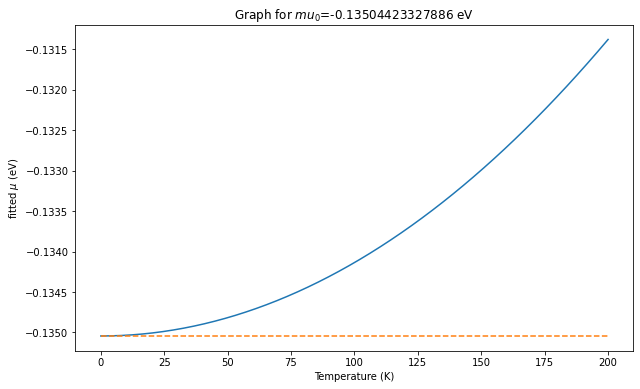

In [21]:
plt.figure(figsize=(10,6))
plt.plot(temps, temp_to_ev(np.array(mus)))
plt.plot(temps, temp_to_ev(mu_0/k_b)*np.ones(len(temps)), "--")
plt.title("Graph for $mu_0$={} eV".format(temp_to_ev(mu_0/k_b)))
plt.xlabel("Temperature (K)")
plt.ylabel("fitted $\mu$ (eV)")

plt.savefig("graphs/mus for shift")
plt.show()
func = (temps, mus)

In [26]:
from tqdm import tqdm

shifts = np.linspace(-2320,-400) * k_b
data = []
for mu_0 in tqdm(shifts):
    temps = np.linspace(0,200,20)
    mus = []
    sim_mus = []
    for temp in temps:
        try:
            mus.append(-calc_mu(mu_0, temp) / k_b)
            sim_mus.append(optimize_mu(mu_0,temp)/k_b)
        except:
            print("Domain error on",  mu_0/k_b, temp)

    data.append((temps,mus, sim_mus)) # will contain a list of tuples which have the temp, mu data
np.save("mu-temp data theory and sim", data)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\284869011.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\284869011.py:48: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\284869011.py:65: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N_fitted = integrate.quad(fitted , -bound_max*k_b, bound_max*k_b)
C:\Users\sfska\AppData\Local\Temp\ipykernel_15916\284869011.py:48: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp((x-mu)/(k_b*T)) + 1)
100%|██████████| 50/50 [09:31<00:00, 11.44s/it]


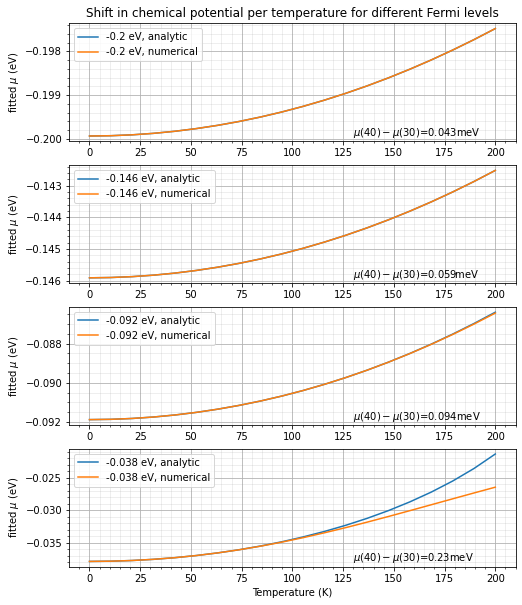

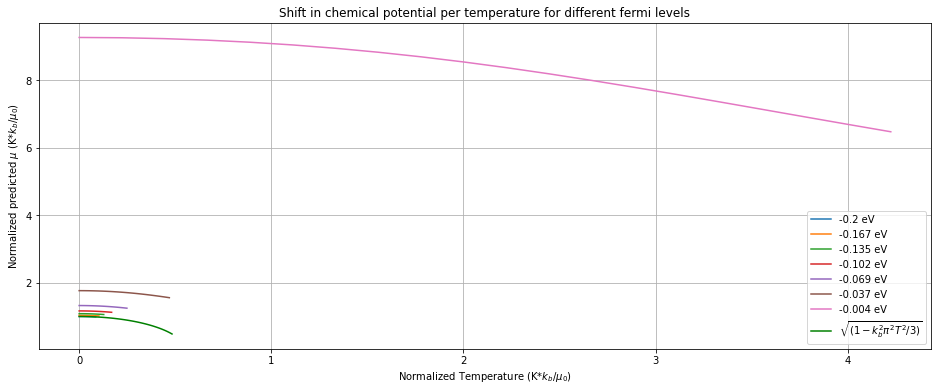

In [36]:
# data = np.load("mu-temp data larger.npy")
data = np.load("mu-temp data theory and sim.npy")
%matplotlib inline


datas = [data[i] for i in np.arange(0,len(data),16)]
fig, axs = plt.subplots(len(datas),1 , figsize=(8,10))
for i,d in enumerate(datas):
    temps,mus, sim_mus = d
    mus = mus*k_b*j_to_ev
    sim_mus = sim_mus*k_b*j_to_ev
    axs[i].plot(temps, mus, label="{} eV, analytic".format(round(mus[0], 3)))
    axs[i].plot(temps, sim_mus, label="{} eV, numerical".format(round(mus[0], 3)))
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylabel("fitted $\mu$ (eV)")
    axs[i].minorticks_on()
    axs[i].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # ax2 = axs[i].secondary_yaxis('right',
    #              functions = (lambda x: 1000*(x-min(mus)), lambda x: 1000*(x+min(mus))))
    # ax2.set_ylabel("shift in meV")
    axs[i].text(130, mus[0], "$\mu(40)-\mu(30)$={}meV".format(
        round(1000*get_diff_in_temps((temps,mus),40,30)[0],3)))

axs[-1].set_xlabel("Temperature (K)")
axs[0].set_title("Shift in chemical potential per temperature for different Fermi levels")
plt.ylabel("fitted $\mu$ (eV)")



plt.savefig("graphs/Predicted potential shifts for Fermi levels")
plt.show()

plt.figure(figsize=(16,6))
for i in np.arange(0,len(data),8):
    temps,mus, sim_mus = data[i]/shifts[i]*k_b
    plt.plot(-temps, sim_mus, label="{} eV".format(round(temp_to_ev(shifts[i]/k_b), 3)))


plt.xlabel("Normalized Temperature (K*$k_b$/$\mu_0$)")
plt.grid()
plt.title("Shift in chemical potential per temperature for different fermi levels")
plt.ylabel("Normalized predicted $\mu$ (K*$k_b$/$\mu_0$)")

# ax2 = plt.gca().secondary_xaxis('right', functions = (lambda x: x*k_b*j_to_ev, lambda x: x/k_b/j_to_ev))
# ax2.set_ylabel("eV")

domain = -np.linspace(-3.5e22*k_b,0)
out = np.sqrt(1-pi**2*k_b**2/3*(domain/k_b)**2)
plt.plot(domain, out, color='green', label="$\sqrt{(1-k_b^2 \pi^2 T^2/3)}$")
plt.legend()

plt.savefig("graphs/Normalized predicted potential shifts for Fermi levels")
plt.show()


plt.show()